<a href="https://colab.research.google.com/github/Shukriy/fastai/blob/master/Pneumonia_Image_Dataset_Fastai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline


In [18]:
!pip install "torch==1.4" "torchvision==0.5.0"

In [19]:
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [0]:
from fastai.vision import *
from fastai.metrics import error_rate

In [0]:
bs = 64
# bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart

## Looking at the data

In [0]:
path = '/content/drive/My Drive/kaggle/chest_xray'

In [0]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(),  size=224, bs=bs).normalize(imagenet_stats)

In [24]:
data.classes

['NORMAL', 'PNEUMONIA']

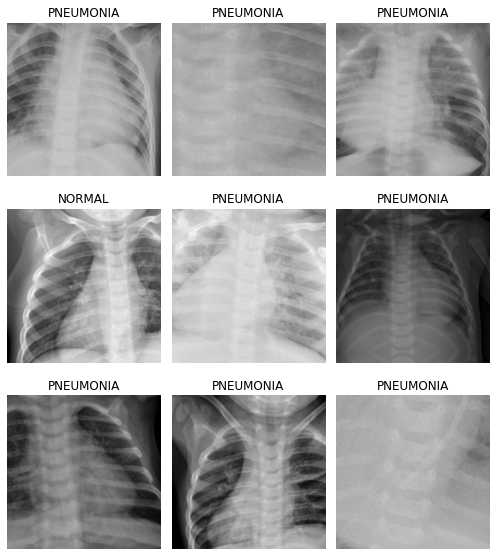

In [25]:
data.show_batch(rows=3, figsize=(7,8))

In [26]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['NORMAL', 'PNEUMONIA'], 2, 9370, 2342)

##Training: resnet34

In [0]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [28]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [29]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.371117,0.201008,0.065756,08:22
1,0.210038,0.194487,0.070026,08:17
2,0.152718,0.132269,0.048676,08:19
3,0.133707,0.141742,0.052092,08:23


In [0]:
learn.save('stage-1')

##Results

In [33]:
interpret = ClassificationInterpretation.from_learner(learn)
losses, idxs = interpret.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

True

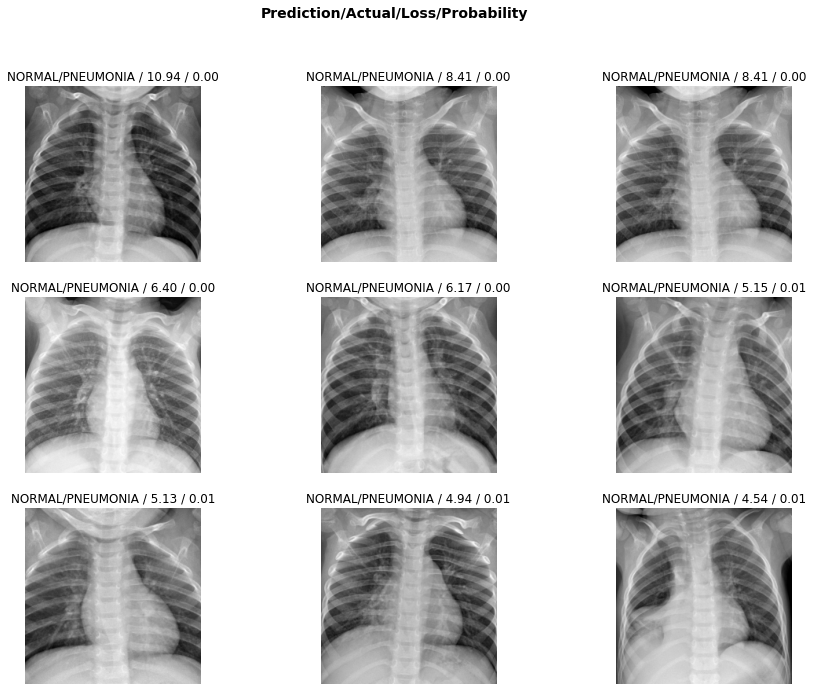

In [38]:
interpret.plot_top_losses(9, figsize=(15,11))

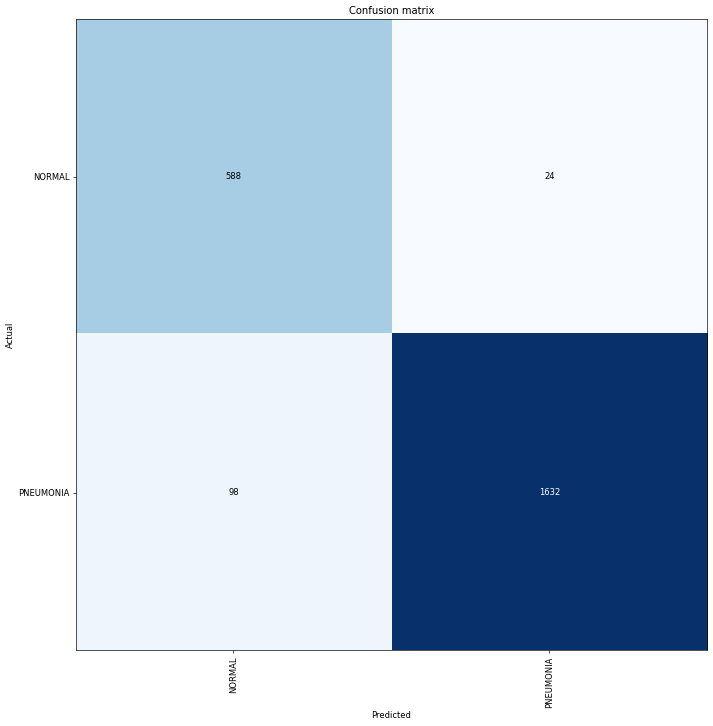

In [40]:
interpret.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [42]:
interpret.most_confused(min_val=2)

[('PNEUMONIA', 'NORMAL', 98), ('NORMAL', 'PNEUMONIA', 24)]

##Unfreezing, fine-tuning, and learning rates

In [0]:
learn.unfreeze()

In [44]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.118919,0.079799,0.026473,08:36


In [0]:
learn.load('stage-1')

In [47]:
learn.lr_find()

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


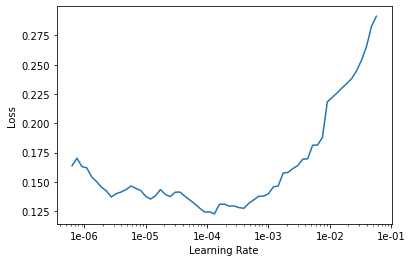

In [48]:
learn.recorder.plot()

In [50]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.084595,0.068685,0.025619,08:33
1,0.081315,0.074811,0.024765,08:33


##Training: resnet50

In [0]:
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(),  size=299, bs=bs//2).normalize(imagenet_stats)

In [54]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


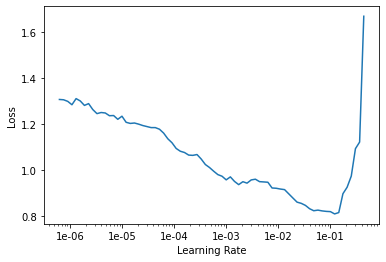

In [55]:
learn.lr_find()
learn.recorder.plot()

In [56]:
learn.fit_one_cycle(8)

epoch,train_loss,valid_loss,error_rate,time
0,0.349460,0.221431,0.064048,11:38
1,0.198046,0.209151,0.067891,11:39
2,0.155730,0.101976,0.032451,11:41
3,0.138305,0.101764,0.037148,11:38
4,0.105185,0.076186,0.029462,11:37
5,0.089351,0.058123,0.022630,11:41
6,0.086882,0.051558,0.017506,11:38
7,0.076631,0.055651,0.022203,11:41


In [0]:
learn.save('stage-1-50')

In [58]:
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.074057,0.068559,0.028181,12:15
1,0.061711,0.049966,0.021349,12:14
2,0.054035,0.044970,0.017933,12:07


In [0]:
learn.load('stage-1-50');

In [60]:
interp = ClassificationInterpretation.from_learner(learn)

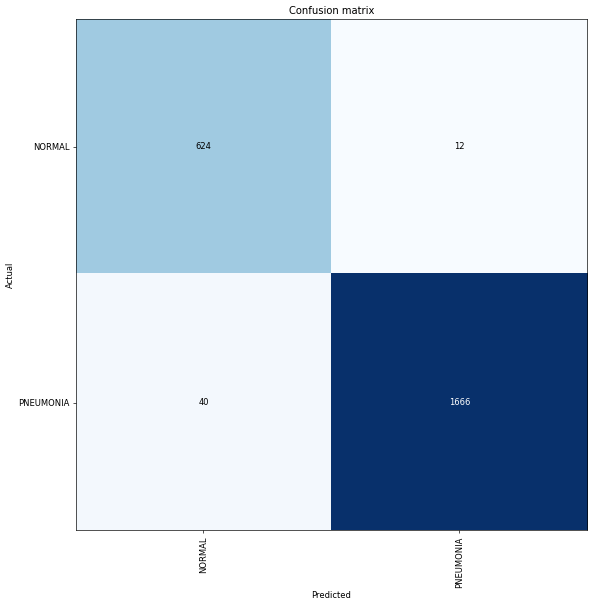

In [61]:
interp.plot_confusion_matrix(figsize=(10,10), dpi=60)

In [62]:
interp.most_confused(min_val=2)

[('PNEUMONIA', 'NORMAL', 40), ('NORMAL', 'PNEUMONIA', 12)]